In [22]:
import numpy as np
import h5py
import scipy.io
import keras as K
from keras.preprocessing import sequence
from keras.optimizers import RMSprop
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution1D, MaxPooling1D
from keras.engine.input_layer import Input
from keras.regularizers import l2, l1
from keras.constraints import maxnorm
from keras.models import Model
from keras.layers.recurrent import LSTM, GRU
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
import metrics
import keras_metrics
import tensorflow as tf
from keras.utils import to_categorical
from keras.backend.tensorflow_backend import set_session
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, f1_score, auc, confusion_matrix

In [2]:
# Limit GPU usage
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
                                    # (nothing gets printed in Jupyter, only if you run it standalone)
sess = tf.Session(config=config)
set_session(sess)  # set this TensorFlow session as the default session for Keras

In [38]:
def create_weighted_binary_crossentropy(zero_weight, one_weight):

    def weighted_binary_crossentropy(y_true, y_pred):

        # Original binary crossentropy (see losses.py):
        # K.mean(K.binary_crossentropy(y_true, y_pred), axis=-1)

        # Calculate the binary crossentropy
        b_ce = K.losses.binary_crossentropy(y_true, y_pred)

        # Apply the weights
        weight_vector = y_true * one_weight + (1. - y_true) * zero_weight
        weighted_b_ce = weight_vector * b_ce

        # Return the mean error
        return K.backend.mean(weighted_b_ce)

    return weighted_binary_crossentropy

In [37]:
def focal_loss(gamma=2., alpha=.25):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        print("hello")
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        print("world")
        return -K.backend.sum(alpha * K.backend.pow(1. - pt_1, gamma) * K.backend.log(pt_1))-K.backend.sum((1-alpha) * K.backend.pow( pt_0, gamma) * K.backend.log(1. - pt_0))
    return focal_loss_fixed

In [36]:
# Defined a metric for determining model accuracy
class Metrics(Callback):
    def __init__(self):
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []
    def on_train_begin(self, logs={}):
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []
            
    def on_epoch_end(self, epoch, logs={}):
        val_predict = (np.asarray(self.model.predict(self.validation_data[0]))).round()
        val_targ = self.validation_data[1]
        _val_f1 = f1_score(val_targ, val_predict, average = None)
        _val_recall = recall_score(val_targ, val_predict, average = None)
        _val_precision = precision_score(val_targ, val_predict, average = None)
        self.val_f1s.append(_val_f1)
        self.val_recalls.append(_val_recall)
        self.val_precisions.append(_val_precision)
        #print(len(_val_precision))
        print ("-- val_f1: " + str(_val_f1) +" — val_precision: "  + str(_val_precision) + "  — val_recall: " + str(_val_recall))
        return

In [39]:
metrcs = Metrics()

In [3]:
DATA = 2200000
number = 345

In [15]:
print('loading training data')
trainmat = h5py.File('../data/res_train.mat')
#xtr = np.transpose(np.array(trainmat['trainxdata'][:,:,DATA:]), axes=(2,0,1))
#ytr = np.array(trainmat['traindata'][0,DATA:]).T
print('finished loading training data')

loading training data
finished loading training data


In [16]:
y = trainmat['traindata'][number]
ind = np.argwhere(y==1)
ind = ind.reshape(ind.shape[0])
print(len(ind))
x_negs = np.random.randint(0,4400000, int(len(ind)*1.2))

34194


In [17]:
print('loading validation data')
validmat = scipy.io.loadmat('../data/res_valid.mat')
print('finished loading validation data')
sum(validmat['validdata'][:,number])

loading validation data
finished loading validation data


42

In [103]:
print('loading validation data')
testmat = scipy.io.loadmat('../data/test.mat')
print('finished loading validation data')

loading validation data
finished loading validation data


AttributeError: 'dict' object has no attribute 'shape'

In [107]:
sum(testmat['testdata'][:,number])

2968

In [30]:
index = np.argmax(ind > DATA)
x_negs.sort()
index_b = np.argmax(x_negs > DATA)

In [29]:
x_in = trainmat['trainxdata'][:,:,:DATA]

In [31]:
x_a1 = x_in[:,:,ind[:index]]
x_b1 = x_in[:,:,x_negs[:index_b]]
x_a1 = np.transpose(x_a1, axes=(2,0,1))
x_b1 = np.transpose(x_b1, axes=(2,0,1))

In [32]:
x_in = 0
x_in = trainmat['trainxdata'][:,:,DATA:]

In [33]:
x_a2 = x_in[:,:,ind[index:]-DATA]
x_b2 = x_in[:,:,x_negs[index_b:]-DATA]
x_a2 = np.transpose(x_a2, axes=(2,0,1))
x_b2 = np.transpose(x_b2, axes=(2,0,1))


In [34]:
x_train_pos = np.vstack([x_a1,x_a2])
x_train_neg = np.vstack([x_b1,x_b2])
x_train = np.vstack([x_train_pos, x_train_neg])

In [35]:
y_train_pos = y[ind]
y_train_neg = y[x_negs]
y_train = np.concatenate([y_train_pos, y_train_neg])

In [36]:
np.save("x_train_" + str(number), x_train)
np.save("y_train_" + str(number), y_train)

In [5]:
x_train = np.load("x_train_345.npy")
y_train = np.load("y_train_345.npy")

In [203]:
x = Input(shape = (200,4))
conv1 = Convolution1D(filters=128,
                        padding="same",
                        activation="relu",
                        kernel_size=5,
                         kernel_initializer=K.initializers.TruncatedNormal(mean=0.0, stddev=0.1, seed=None))
conv2 = Convolution1D(filters=128,
                        padding="same",
                        activation="relu",
                        kernel_size=5,
                         kernel_initializer=K.initializers.TruncatedNormal(mean=0.0, stddev=0.1, seed=None))
conv3 = Convolution1D(filters=128,
                        padding="same",
                        activation="relu",
                        kernel_size=5, 
                     kernel_initializer=K.initializers.TruncatedNormal(mean=0.0, stddev=0.1, seed=None))
max1 = MaxPooling1D(pool_size=13, strides=13)
dropout1 = Dropout(0.2)
conv4 = Convolution1D(filters=128,
                        padding="same",
                        activation="relu",
                        kernel_size=5,
                         kernel_initializer=K.initializers.TruncatedNormal(mean=0.0, stddev=0.1, seed=None))
conv5 = Convolution1D(filters=128,
                        padding="same",
                        activation="relu",
                        kernel_size=5,
                         kernel_initializer=K.initializers.TruncatedNormal(mean=0.0, stddev=0.1, seed=None))
max2 = MaxPooling1D(pool_size=5, strides = 2)
dropout2 = Dropout(0.2)
flatten1 = Flatten()
dense1 = Dense(32)
dense2 = Dense(10, activation = 'relu')
dense3 = Dense(2, activation = 'softmax')

In [204]:
#Create the model connections
y1 = conv1(x)
y2 = conv2(y1)
y22 = conv3(y2)
y3 = K.layers.add([y1, y22])
y4 = max1(y3)
y5 = dropout1(y4)
y6 = conv4(y5)
y7 = conv5(y6)
y8 = K.layers.add([y5, y7])
y9 = max2(y8)
y10 = dropout2(y9)
y11 = flatten1(y10)
y12 = dense1(y11)
y13 = dense2(y12)
y14 = dense3(y13)
# model = Sequential()
# model.add(Convolution1D(16, 3, input_shape=(200, 4), padding='same', name='conv1'))
# model.add(Activation('relu', name='a1'))
# model.add(MaxPooling1D())
# model.add(Convolution1D(24, 3, padding='same', name='conv2'))
# model.add(Activation('relu', name='a2'))
# model.add(MaxPooling1D())
# model.add(Convolution1D(32, 3, padding='same', name='conv3'))
# model.add(Activation('relu', name='a3'))
# model.add(MaxPooling1D())
# model.add(Flatten())
# model.add(Dense(2, name='fc1'))
# model.add(Dropout(0.2))
# model.add(Activation('softmax', name = 'a4'))

In [205]:
model = Model(x, y14)
model.compile(loss=focal_loss(), optimizer='adam', metrics=['accuracy'])

hello
world


In [206]:
checkpointer = ModelCheckpoint(filepath="final_balanced_"+str(number)+".hdf5", verbose=1, save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss', patience=20, verbose=1)

In [207]:
# Create validation dataset
valid_x = np.transpose(validmat['validxdata'],axes=(0,2,1))[:,400:600,:]
valid_y = validmat['validdata'][:,number]

test_x = np.transpose(testmat['testxdata'],axes=(0,2,1))[:,400:600,:]
test_y = testmat['testdata'][:,number]


l = to_categorical(y_train)
print(l.shape)
print(sum(valid_y)/len(valid_y))
print(sum(test_y)/len(test_y))

(75226, 2)
0.00525
0.006522732866837793


In [208]:
history = model.fit(x_train[:,400:600,:], to_categorical(y_train), 
          batch_size=512, 
          epochs=40, 
          shuffle=True, 
          validation_data=(valid_x, to_categorical(valid_y)),
          callbacks=[checkpointer,earlystopper])

Train on 75226 samples, validate on 8000 samples
Epoch 1/40
75226/75226 [==============================] - 2s 24us/step - loss: 46.5449 - acc: 0.8427 - val_loss: 51.1140 - val_acc: 0.8485

Epoch 00001: val_loss improved from inf to 51.11404, saving model to final_balanced_345.hdf5
Epoch 2/40
75226/75226 [==============================] - 1s 12us/step - loss: 46.4078 - acc: 0.8431 - val_loss: 52.2793 - val_acc: 0.8423

Epoch 00002: val_loss did not improve from 51.11404
Epoch 3/40
75226/75226 [==============================] - 1s 12us/step - loss: 46.1778 - acc: 0.8437 - val_loss: 37.9948 - val_acc: 0.8938

Epoch 00003: val_loss improved from 51.11404 to 37.99483, saving model to final_balanced_345.hdf5
Epoch 4/40
75226/75226 [==============================] - 1s 12us/step - loss: 46.2044 - acc: 0.8450 - val_loss: 60.5133 - val_acc: 0.8146

Epoch 00004: val_loss did not improve from 37.99483
Epoch 5/40
75226/75226 [==============================] - 1s 12us/step - loss: 46.4963 - acc: 0.

In [220]:
# model = load_model("balanced.hdf5")

In [209]:
preds = model.predict(valid_x)
preds = preds[:,1].reshape(preds.shape[0])
print(number)
valid_labels = valid_y

345


In [210]:
f1_score(valid_y, preds > 0.5, pos_label=1)

0.056206088992974246

In [211]:
fpr, tpr, thresholds = roc_curve(valid_y, preds, pos_label = 1)
roc_auc = auc(fpr, tpr)

In [212]:
print(roc_auc)

0.9310457281681208


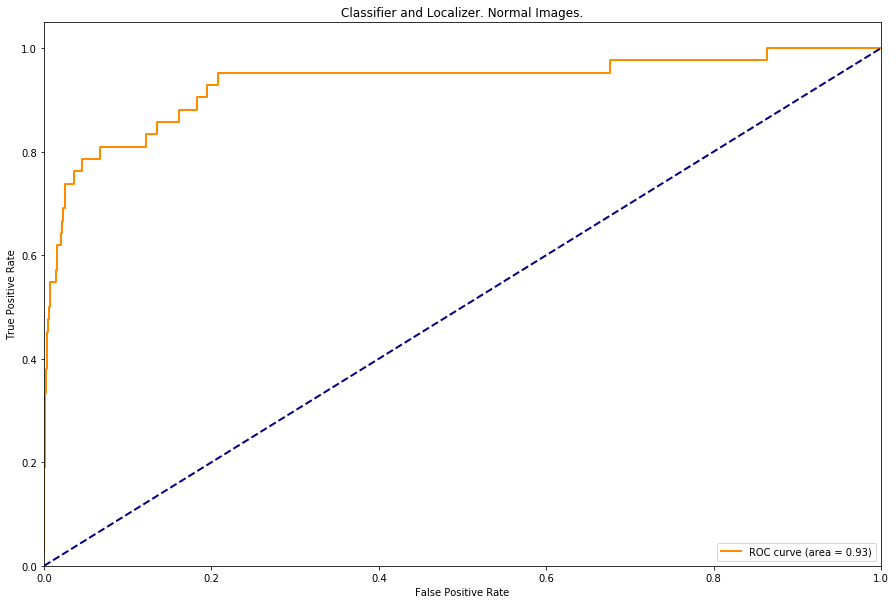

In [214]:
fig_size = plt.rcParams["figure.figsize"] = [15, 10]
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Classifier and Localizer. Normal Images.')
plt.legend(loc="lower right")
plt.show()

In [215]:
confusion_matrix(valid_y, preds > 0.5)

array([[6755, 1203],
       [   6,   36]])

In [216]:
import keras.backend as B
fig_size = plt.rcParams["figure.figsize"] = [150, 100]

In [220]:
# class_name should be one of EI, IE or N
def visualizeClass():
    
    loss = B.mean(model.output[:,1])
    input_seq = model.input
    grads = B.gradients(loss, input_seq)[0]
    iterate = B.function([input_seq], [loss, grads])
    sequence = np.zeros((1, 200, 4))
    sequence[:] = 0.25
    step_size = 1. # Gradient ascent step size
    
    # Perform gradient ascent in the direction of the target class
    for i in range(5000):
        loss_value, grads_value = iterate([sequence])
        #print(grads_value.shape)
        sequence += grads_value * step_size
    
    
    #print(sequence)
    sequence[0] /= np.linalg.norm(sequence[0], 1, axis=0)
    sequence = np.clip(sequence, 0, 1)
    
    plt.title(" Visualization")
    plt.imshow(sequence[0].T, cmap='viridis')
    #plt.xticks(np.arange(200), np.arange(200)+1)
    plt.yticks(np.arange(4), ('A', 'G', 'C', 'T'))
    # Uncomment the line below to save the figure as an image
    # plt.savefig('ClassVisualization' + class_name + '.png')
    plt.show()


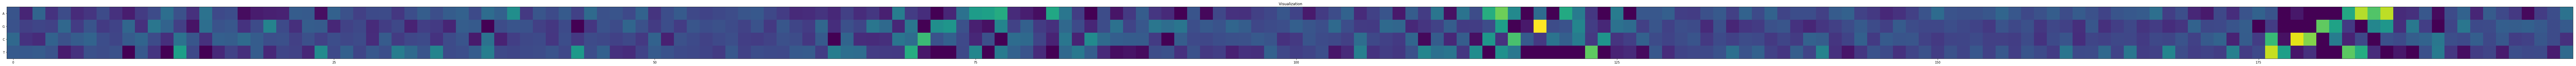

In [221]:
visualizeClass()

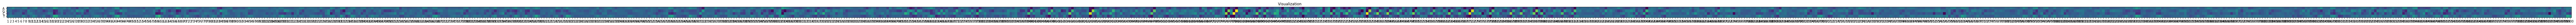

In [136]:
visualizeClass()

In [222]:
from ann_visualizer.visualize import ann_viz

In [223]:
ann_viz(model, title="Artificial Neural network - Model Visualization")

ValueError: ANN Visualizer: Layer not supported for visualizing

In [224]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

OSError: `pydot` failed to call GraphViz.Please install GraphViz (https://www.graphviz.org/) and ensure that its executables are in the $PATH.